In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score
from collections import Counter

import statsmodels.api as sm

In [3]:
cal = pd.read_csv('calendar.csv.gz')
listd = pd.read_csv('listings.csv.gz')
lists = pd.read_csv('listings.csv')
revs = pd.read_csv('reviews.csv.gz')
nhood = pd.read_csv('neighbourhoods.csv')
purelst = pd.read_csv('listings.csv.gz')

In [4]:
# pd.set_option('display.max_colu?mns', 96)
pd.set_option('display.max_rows', 96)

In [5]:
#CLEANUP incoming dataframes

listd_drop_cols = ['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','xl_picture_url',\
                   'host_name','host_location','neighbourhood_group_cleansed','square_feet',\
                   'maximum_nights','is_business_travel_ready']

# listd_numc_cols
# listd_catz_cols

print(len(listd.columns), len(listd_drop_cols))
listd.drop(listd_drop_cols,axis=1,inplace=True )
print(len(listd.columns), len(listd_drop_cols))

96 12
84 12


# ALL TRANSFORMATIONS FUNCTIONS  : 

In [6]:
print(cal.date.min(),cal.date.max())
print(revs.date.min(),revs.date.max())
# print(lists.last_review.min(),lists.last_review.max())

2018-07-05 2019-07-04
2009-05-03 2018-07-05


In [7]:
# tmp=listd.copy() # Create a new copy of the existing dataframe otherwise it is only by reference
# tmp.head().T

In [8]:
def price_xform(dframe,colname):
    dframe[colname]=dframe[colname].str.replace('$','')
    dframe[colname]=dframe[colname].str.replace(',','')
    dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [9]:
def cat_rename(dframe,colname,src,tgt):
    dframe[colname]=dframe[colname].str.replace(src,tgt)
#     dframe[colname]=dframe[colname].str.replace(',','')
#     dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [10]:
def create_dummies(dframe,colname):
#     dfnew=dframe.copy()
    dframe=pd.get_dummies(data=dframe, columns=[colname])# create dummies and drop the parent column
    dframe.drop(columns=[dframe.columns[-1]],inplace=True) #dropped the last column from the add dummies
    return dframe

In [11]:
#Impute Null Rows based on the specified column
def impute_nullrows(dframe,colname):
    print(dframe[colname].isnull().sum())
    dftmp=dframe[~dframe[colname].isnull()]   # remove nulls from one column
    print(dftmp[colname].isnull().sum())
    return dftmp


# TRANSFORM ACTIONS

In [12]:
# Convert to Booleans
listd['host_is_superhost'] = listd.apply(lambda x:  x.host_is_superhost=='t', axis= 1)
listd['host_has_profile_pic'] = listd.apply(lambda x:  x.host_has_profile_pic=='t', axis= 1)
listd['host_identity_verified'] = listd.apply(lambda x:  x.host_identity_verified=='t', axis= 1)
listd['instant_bookable'] = listd.apply(lambda x:  x.instant_bookable=='t', axis= 1)

In [13]:
#Transform all the price columns to remove "$" and ","

price_xform(listd,'price')
price_xform(listd,'weekly_price')
price_xform(listd,'monthly_price')
price_xform(listd,'security_deposit')
price_xform(listd,'cleaning_fee')
price_xform(listd,'extra_people')

In [14]:
#Transform the room_type . to create a meaningful name and create dummies

cat_rename(listd,'room_type','Entire home/apt','full')
cat_rename(listd,'room_type','Private room','pvt')
cat_rename(listd,'room_type','Shared room','shared')

listd=create_dummies(listd,'room_type')
# listd=pd.get_dummies(data=listd, columns=['room_type'])  # create dummies and drop the parent column
# listd.drop(columns=[listd.columns[-1]],inplace=True)  #dropped the last column from the add dummies

In [15]:
#Transform the bed_type . to create a meaningful name and create dummies
listd['bed_type'] = listd.apply(lambda x: x.bed_type=='Real Bed', axis=1)

In [16]:
#Put a count on amenities,   IF it does not work, pick the most important feature
listd['amentcnt'] =   listd.apply(lambda x: len(x.amenities.split(",")), axis=1)

In [17]:
#!!! APPLY the same for the test data also
#Impute the to remove the rows with no zipcode.  !!! APPLY the same for the test data also
listd=listd[~listd['zipcode'].isnull()]   # remove nulls from one column




In [18]:
#Impute the null values with meaningful data

listd['cleaning_fee']=listd['cleaning_fee'].fillna(0)
listd['review_scores_cleanliness'] = listd['review_scores_cleanliness'].fillna(listd.review_scores_cleanliness.mean())

listd['review_scores_location'] = listd['review_scores_location'].fillna(listd.review_scores_location.mean())
listd['review_scores_value'] = listd['review_scores_value'].fillna(listd.review_scores_value.mean())




In [19]:
# mask1 = listd['minimum_nights']>7 
# mask2 = listd['minimum_nights']<=32
# maskmid=mask1 & mask2 
# maskmid = (listd['minimum_nights']>7) & (listd['minimum_nights']<=32)
# mask2
# maskmid
listd.loc[listd['minimum_nights']<=7,'min_night_stay'] = 'short'
listd.loc[(listd['minimum_nights']>7) & (listd['minimum_nights']<=32),'min_night_stay'] = 'mid'
listd.loc[listd['minimum_nights']>32,'min_night_stay'] = 'long'
listd=create_dummies(listd,'min_night_stay')

In [20]:
#Condensing the property_type to sub categories

listd.loc[listd['property_type']=='Apartment', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Condominium', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guest suite', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Townhouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guesthouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Tiny house', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Timeshare', 'ppt_condensed'] = 'apt'

listd.loc[listd['property_type']=='Serviced apartment', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Bed and breakfast', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Treehouse', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Cabin', 'ppt_condensed'] = 'aptspl'

listd.loc[listd['property_type']=='Bus', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Boat', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Camper/RV', 'ppt_condensed'] = 'auto'

listd.loc[listd['property_type']=='Hostel', 'ppt_condensed'] = 'hostel'

listd.loc[listd['property_type']=='Boutique hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Resort', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Aparthotel', 'ppt_condensed'] = 'hotel'

listd.loc[listd['property_type']=='House', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Bungalow', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Cottage', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Villa', 'ppt_condensed'] = 'house'

listd.loc[listd['property_type']=='Other', 'ppt_condensed'] = 'other'

listd.loc[listd['property_type']=='Loft', 'ppt_condensed'] = 'room'

listd=create_dummies(listd,'ppt_condensed')

In [21]:
listd=create_dummies(listd,'zipcode')

In [22]:
#imputing some more missing values

listd['cleaning_fee'].fillna(0, inplace=True)
listd['beds'].fillna(0, inplace=True)
listd['bathrooms'].fillna(0, inplace=True)

In [23]:
listd.shape

(4669, 122)

In [24]:
#Removed the rows with price is equal to zero
listd=listd[listd.price>0]
listd.shape

(4662, 122)

In [25]:
# lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds',\
#              'bathrooms','guests_included','zipcode']

listd_drop_cols2=['id', 'listing_url', 'name', 'summary', 'space', 'description',\
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',\
       'house_rules', 'picture_url', 'host_id', 'host_url', 'host_since',\
       'host_about', 'host_response_time', 'host_response_rate',\
       'host_acceptance_rate', 'host_thumbnail_url',\
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',\
       'host_total_listings_count', 'host_verifications',\
       'host_has_profile_pic', 'street',\
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',\
       'market', 'smart_location', 'country_code', 'country', 'latitude',\
       'longitude', 'is_location_exact', 'property_type',\
       'amenities',\
       'weekly_price', 'monthly_price', 'security_deposit',\
       'extra_people', 'minimum_nights', 'calendar_updated',\
       'has_availability', 'availability_30', 'availability_60',\
       'availability_90', 'availability_365', 'calendar_last_scraped',\
       'number_of_reviews', 'first_review', 'last_review',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'requires_license', 'license',\
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',\
       'require_guest_profile_picture', 'require_guest_phone_verification',\
       'calculated_host_listings_count', 'reviews_per_month']
listd.drop(listd_drop_cols2,axis=1,inplace=True )

In [26]:
listd.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'room_type_full', 'room_type_pvt', 'amentcnt',
       'min_night_stay_long', 'min_night_stay_mid', 'ppt_condensed_apt',
       'ppt_condensed_aptspl', 'ppt_condensed_auto', 'ppt_condensed_hostel',
       'ppt_condensed_hotel', 'ppt_condensed_house', 'ppt_condensed_other',
       'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',
       'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',
       'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',
       'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',
       'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',
       'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',
       'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',
       'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',
       'zipcode_94132.0', 'zipcode_94133.0

In [27]:
listd.shape
purelst[purelst.price =='$0.00'].T
# purelst.head().T

,3553,3605,3606,3607,3608,3609,3615
id,20331804,20625135,20626299,20626447,20635128,20635250,20652378
listing_url,https://www.airbnb.com/rooms/20331804,https://www.airbnb.com/rooms/20625135,https://www.airbnb.com/rooms/20626299,https://www.airbnb.com/rooms/20626447,https://www.airbnb.com/rooms/20635128,https://www.airbnb.com/rooms/20635250,https://www.airbnb.com/rooms/20652378
scrape_id,20180705131954,20180705131954,20180705131954,20180705131954,20180705131954,20180705131954,20180705131954
last_scraped,2018-07-05,2018-07-05,2018-07-05,2018-07-05,2018-07-05,2018-07-05,2018-07-05
name,Cozy Victorian Bedroom in Mission,Cheap. Safe and Comfortable,Coliving in a quiet and safe neighborhood,Room for female close to public transport,Calling all techies/stay at a hacker house!,Hacker house in quiet location,World traveler coliving
summary,"Steps from Mission St, this private room provi...",Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...
space,This bedroom has a unique Victorian San Franci...,This specific room with the twin beds has 2 be...,The space This specific room with the twin bed...,This specific room with the twin beds has 2 be...,This specific room with the twin beds has 2 be...,This specific room with the twin beds has 2 be...,This specific room with the twin beds has 2 be...
description,"Steps from Mission St, this private room provi...",Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...,Welcome to hacker/co-living house for entrepre...
experiences_offered,none,none,none,none,none,none,none
neighborhood_overview,The apartment is located in the La Lengua Area...,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
y=listd.price
X=listd.copy()
X=X.drop(['price'],axis=1)

In [29]:
# X=dflreg.drop([listd_insig_cols],axis=1)
# listd.drop(listd_drop_cols,axis=1,inplace=True )

In [30]:
X_chunk, X_test, y_chunk, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
X_train, X_vald, y_train, y_vald = train_test_split(X_chunk, y_chunk, test_size=0.20, random_state=47)

In [ ]:
def my_metric(y_act,y_pred):
    r2_score= (1 - ((y_act-y_pred) ** 2).sum() / ((y_act-y_act.mean())**2).sum() )
#     print("My R2Score = ",r2_score)
    return(r2_score)

In [31]:
X_train = X_chunk.copy()
y_train = y_chunk.copy()

In [32]:
print(X_train.shape, X_vald.shape, X_test.shape)
print(y_train.shape, y_vald.shape, y_test.shape)

(3729, 49) (746, 49) (933, 49)
(3729,) (746,) (933,)


In [33]:
X_train.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,cleaning_fee,guests_included,room_type_full,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
3884,False,False,4,1.0,1,1.0,True,35.0,1,1,...,0,0,0,0,0,0,0,0,0,0
3945,False,False,8,3.0,5,6.0,True,200.0,8,1,...,0,0,0,0,0,0,0,0,0,0
3908,False,True,2,1.0,1,1.0,True,80.0,1,1,...,0,0,0,0,0,0,0,0,0,0
2273,True,True,2,1.0,1,1.0,True,50.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3473,False,False,6,1.0,1,3.0,True,0.0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
# X_train._get_numeric_data().info()

In [35]:
# -------------------------------------------------------

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

[0.         0.         0.0877702  0.01422195 0.78089472 0.
 0.         0.03926092 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.07785222 0.
 0.        ]


<BarContainer object of 49 artists>

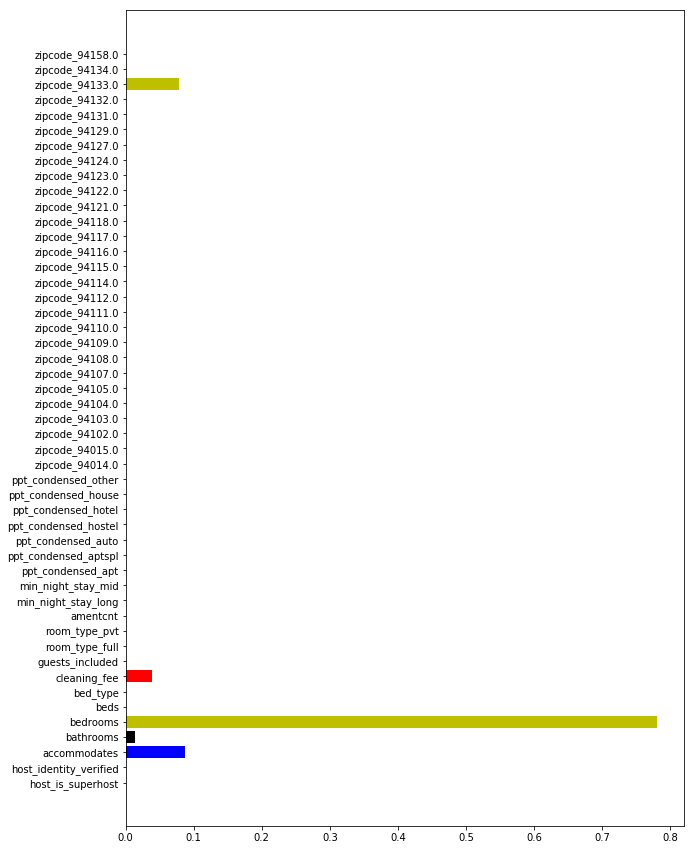

In [37]:
featurelist=X_train.columns
featureimp= regr.feature_importances_
print(featureimp)

fig=plt.figure(figsize=(10,15))
ax1=fig.add_subplot(111)
ax1.barh(featurelist,featureimp,color='rgbkymc')

In [38]:
print(regr.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

[148.7608447]


In [39]:
X_test.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,cleaning_fee,guests_included,room_type_full,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
4327,True,False,1,1.0,0,1.0,True,55.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2326,True,True,2,1.0,1,1.0,True,40.0,2,0,...,0,0,0,0,0,0,0,0,0,0
3190,False,True,6,2.5,3,3.0,True,150.0,1,1,...,0,0,0,0,0,0,0,0,0,0
1900,True,False,8,2.0,3,4.0,True,185.0,8,1,...,0,0,0,0,0,0,0,1,0,0
1622,False,True,2,1.0,1,1.0,True,46.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
y_pred=regr.predict(X_test)

rf_score=regr.score(X_test,y_test)
print("Random Forest Score",rf_score)

#Calculate the baseline errors
baseline = abs(y_test.mean()-y_test)
print("Baseline Absolute Error",np.mean(baseline))

#Calculate the absolute errors
residuals = abs(y_pred-y_test)
print("Mean Absolute Error",np.mean(residuals))

#Calculate Mean Absolute pct error
mape = (residuals/y_test)*100

#Accuracy 
accy=100-np.mean(mape)

#Mean Absolute Error 

print("Accuracy",round(accy,2), '%')

print("My R2 Score is : ",my_metric(y_test,y_pred))

Random Forest Score 0.26934031349840093
Baseline Absolute Error 118.54777257380623
Mean Absolute Error 85.20770644659292
Accuracy 49.82 %


In [41]:
y_pred

array([148.7608447 , 148.7608447 , 464.85057917, 880.28985158,
       148.7608447 , 464.85057917, 178.69274618, 244.00004929,
       148.7608447 , 158.13211165, 492.25455561, 264.56068382,
       464.85057917, 148.7608447 , 148.7608447 , 264.56068382,
       264.56068382, 178.69274618, 148.7608447 , 178.69274618,
       264.56068382, 464.85057917, 148.7608447 , 148.7608447 ,
       148.7608447 , 264.56068382, 148.7608447 , 148.7608447 ,
       264.56068382, 148.7608447 , 148.7608447 , 632.14081022,
       148.7608447 , 148.7608447 , 178.69274618, 464.85057917,
       148.7608447 , 148.7608447 , 148.7608447 , 148.7608447 ,
       148.7608447 , 464.85057917, 148.7608447 , 148.7608447 ,
       178.69274618, 264.56068382, 264.56068382, 158.13211165,
       158.13211165, 148.7608447 , 264.56068382, 148.7608447 ,
       148.7608447 , 264.56068382, 264.56068382, 148.7608447 ,
       148.7608447 , 264.56068382, 178.69274618, 148.7608447 ,
       264.56068382, 148.7608447 , 148.7608447 , 264.56

In [42]:
#Building Residual DF

# dfpred= y_test.to_frame()
dfpred = pd.DataFrame()
dfpred['price'] = y_test
dfpred['rf_preds'] = y_pred
dfpred['rf_resid'] = dfpred.rf_preds-dfpred.price
dfpred['rf_residpct'] = (dfpred.rf_preds-dfpred.price)/dfpred.price
dfpred.head()

,price,rf_preds,rf_resid,rf_residpct
4327,200.0,148.760845,-51.239155,-0.256196
2326,140.0,148.760845,8.760845,0.062577
3190,780.0,464.850579,-315.149421,-0.404038
1900,499.0,880.289852,381.289852,0.764108
1622,93.0,148.760845,55.760845,0.599579


In [43]:
dfpred[dfpred.price > 1000]

,price,rf_preds,rf_resid,rf_residpct
110,1200.0,492.254556,-707.745444,-0.589788
1179,1100.0,464.850579,-635.149421,-0.577409
3481,1968.0,632.140810,-1335.859190,-0.678790
707,1450.0,492.254556,-957.745444,-0.660514
1157,1200.0,264.560684,-935.439316,-0.779533
3693,4000.0,148.760845,-3851.239155,-0.962810
4275,1285.0,492.254556,-792.745444,-0.616923
687,1050.0,464.850579,-585.149421,-0.557285
1952,1285.0,464.850579,-820.149421,-0.638249
2103,1500.0,464.850579,-1035.149421,-0.690100


In [44]:
dfpred[dfpred.price < 100]

,price,rf_preds,rf_resid,rf_residpct
1622,93.0,148.760845,55.760845,0.599579
2008,99.0,158.132112,59.132112,0.597294
1365,65.0,148.760845,83.760845,1.288628
170,45.0,148.760845,103.760845,2.305797
2293,72.0,148.760845,76.760845,1.066123
2497,75.0,148.760845,73.760845,0.983478
1190,66.0,148.760845,82.760845,1.253952
802,50.0,148.760845,98.760845,1.975217
4128,79.0,148.760845,69.760845,0.883049
4149,79.0,148.760845,69.760845,0.883049


Text(0,0.5,'RESIDUAL PCT')

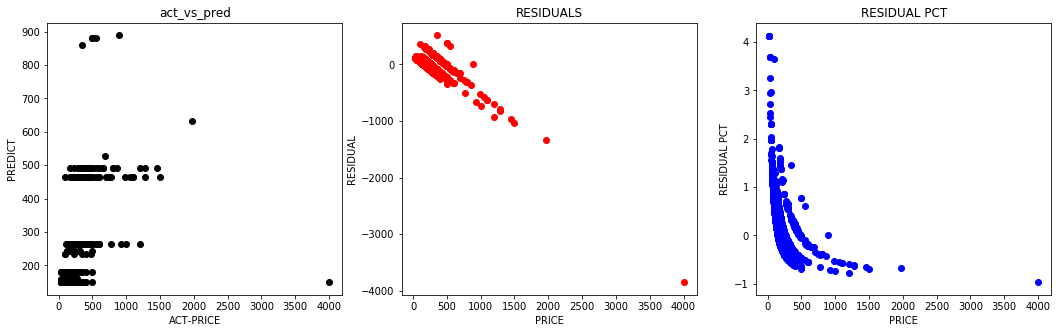

In [45]:
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_test, y_pred,  color='black')
ax1.set_title('act_vs_pred')
ax1.set_xlabel('ACT-PRICE')
ax1.set_ylabel('PREDICT')

ax2.scatter(dfpred.price,dfpred.rf_resid, color='red')
ax2.set_title('RESIDUALS')
ax2.set_xlabel('PRICE')
ax2.set_ylabel('RESIDUAL')

ax3.scatter(dfpred.price,dfpred.rf_residpct, color='blue')
ax3.set_title('RESIDUAL PCT')
ax3.set_xlabel('PRICE')
ax3.set_ylabel('RESIDUAL PCT')

# RANDOM FOREST TUNING

In [46]:
# Random Hyper Parameter Grid

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [49]:
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}


print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [50]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, max_features=sqrt, max_depth=30, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV] n_estimators=400, max_features=sqrt, max_depth=30, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV] n_estimators=400, max_features=sqrt, max_depth=30, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV] n_estimators=2000, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV] n_estimators=2000, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV] n_estimators=1200, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_leaf=2, min_samples_split=5 
[CV] n_estimators=2000, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV] n_estimators=1200, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_leaf=2, min_samples_split=5 
[CV]  n_estimators=400, ma

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.6s


[CV]  n_estimators=1800, max_features=auto, max_depth=10, bootstrap=False, min_samples_leaf=4, min_samples_split=5, total=  16.0s
[CV] n_estimators=800, max_features=sqrt, max_depth=90, bootstrap=False, min_samples_leaf=1, min_samples_split=5 
[CV]  n_estimators=400, max_features=auto, max_depth=70, bootstrap=True, min_samples_leaf=4, min_samples_split=10, total=   3.3s
[CV] n_estimators=800, max_features=sqrt, max_depth=90, bootstrap=False, min_samples_leaf=1, min_samples_split=5 
[CV]  n_estimators=1000, max_features=auto, max_depth=50, bootstrap=False, min_samples_leaf=1, min_samples_split=2, total=  19.3s
[CV] n_estimators=800, max_features=sqrt, max_depth=90, bootstrap=False, min_samples_leaf=1, min_samples_split=5 
[CV]  n_estimators=1000, max_features=auto, max_depth=50, bootstrap=False, min_samples_leaf=1, min_samples_split=2, total=  19.7s
[CV] n_estimators=2000, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_leaf=1, min_samples_split=10 
[CV]  n_estimators=400,

[CV] n_estimators=1400, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_leaf=4, min_samples_split=5 
[CV]  n_estimators=1800, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_leaf=1, min_samples_split=10, total=   6.9s
[CV] n_estimators=1400, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_leaf=4, min_samples_split=5 
[CV]  n_estimators=1600, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_leaf=1, min_samples_split=5, total=   7.3s
[CV] n_estimators=1400, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_leaf=4, min_samples_split=5 
[CV]  n_estimators=1600, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_leaf=1, min_samples_split=5, total=   7.1s
[CV] n_estimators=1800, max_features=auto, max_depth=None, bootstrap=True, min_samples_leaf=2, min_samples_split=2 
[CV]  n_estimators=1600, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_leaf=1, min_samples_split=5, total=   7.2s
[CV] n_estimators=180

[CV]  n_estimators=800, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_leaf=2, min_samples_split=2, total=   3.2s
[CV] n_estimators=800, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_leaf=4, min_samples_split=10 
[CV]  n_estimators=800, max_features=sqrt, max_depth=100, bootstrap=False, min_samples_leaf=1, min_samples_split=5, total=   3.6s
[CV] n_estimators=800, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_leaf=4, min_samples_split=10 
[CV]  n_estimators=2000, max_features=auto, max_depth=100, bootstrap=False, min_samples_leaf=4, min_samples_split=10, total=  25.9s
[CV] n_estimators=1800, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_leaf=4, min_samples_split=2 
[CV]  n_estimators=800, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_leaf=4, min_samples_split=10, total=   1.9s
[CV] n_estimators=1800, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_leaf=4, min_samples_split=2 
[CV]  n_estimators=800, 

[CV]  n_estimators=800, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_leaf=4, min_samples_split=2, total=   2.0s
[CV] n_estimators=200, max_features=auto, max_depth=90, bootstrap=False, min_samples_leaf=2, min_samples_split=5 
[CV]  n_estimators=400, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_leaf=4, min_samples_split=10, total=   1.0s
[CV] n_estimators=1000, max_features=sqrt, max_depth=110, bootstrap=True, min_samples_leaf=1, min_samples_split=2 
[CV]  n_estimators=400, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_leaf=4, min_samples_split=10, total=   1.0s
[CV] n_estimators=1000, max_features=sqrt, max_depth=110, bootstrap=True, min_samples_leaf=1, min_samples_split=2 
[CV]  n_estimators=400, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_leaf=4, min_samples_split=10, total=   1.0s
[CV] n_estimators=1000, max_features=sqrt, max_depth=110, bootstrap=True, min_samples_leaf=1, min_samples_split=2 
[CV]  n_estimators=800, ma

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min


[CV]  n_estimators=600, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_leaf=2, min_samples_split=2, total=   2.4s
[CV] n_estimators=2000, max_features=auto, max_depth=50, bootstrap=False, min_samples_leaf=2, min_samples_split=10 
[CV]  n_estimators=2000, max_features=auto, max_depth=90, bootstrap=True, min_samples_leaf=2, min_samples_split=2, total=  20.2s
[CV] n_estimators=2000, max_features=auto, max_depth=50, bootstrap=False, min_samples_leaf=2, min_samples_split=10 
[CV]  n_estimators=2000, max_features=auto, max_depth=90, bootstrap=True, min_samples_leaf=2, min_samples_split=2, total=  20.6s
[CV] n_estimators=1000, max_features=auto, max_depth=50, bootstrap=False, min_samples_leaf=4, min_samples_split=10 
[CV]  n_estimators=2000, max_features=auto, max_depth=90, bootstrap=True, min_samples_leaf=2, min_samples_split=2, total=  20.4s
[CV] n_estimators=1000, max_features=auto, max_depth=50, bootstrap=False, min_samples_leaf=4, min_samples_split=10 
[CV]  n_estimators=

[CV] n_estimators=1000, max_features=auto, max_depth=80, bootstrap=False, min_samples_leaf=4, min_samples_split=10 
[CV]  n_estimators=1800, max_features=auto, max_depth=80, bootstrap=True, min_samples_leaf=2, min_samples_split=2, total=  18.6s
[CV] n_estimators=1000, max_features=auto, max_depth=80, bootstrap=False, min_samples_leaf=4, min_samples_split=10 
[CV]  n_estimators=1800, max_features=auto, max_depth=80, bootstrap=True, min_samples_leaf=2, min_samples_split=2, total=  18.5s
[CV] n_estimators=1200, max_features=auto, max_depth=None, bootstrap=False, min_samples_leaf=2, min_samples_split=10 
[CV]  n_estimators=1400, max_features=auto, max_depth=100, bootstrap=True, min_samples_leaf=1, min_samples_split=2, total=  17.9s
[CV] n_estimators=1200, max_features=auto, max_depth=None, bootstrap=False, min_samples_leaf=2, min_samples_split=10 
[CV]  n_estimators=1800, max_features=auto, max_depth=80, bootstrap=True, min_samples_leaf=2, min_samples_split=2, total=  18.4s
[CV] n_estimato

[CV]  n_estimators=1800, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_leaf=2, min_samples_split=5, total=   5.2s
[CV] n_estimators=400, max_features=auto, max_depth=90, bootstrap=False, min_samples_leaf=1, min_samples_split=5 
[CV]  n_estimators=1800, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_leaf=2, min_samples_split=5, total=   5.2s
[CV] n_estimators=1600, max_features=auto, max_depth=90, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV]  n_estimators=1800, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_leaf=2, min_samples_split=5, total=   5.2s
[CV] n_estimators=1600, max_features=auto, max_depth=90, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV]  n_estimators=400, max_features=auto, max_depth=90, bootstrap=False, min_samples_leaf=1, min_samples_split=5, total=   6.9s
[CV] n_estimators=1600, max_features=auto, max_depth=90, bootstrap=True, min_samples_leaf=1, min_samples_split=5 
[CV]  n_estimators=400, max_

[CV] n_estimators=800, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_leaf=4, min_samples_split=5 
[CV]  n_estimators=800, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_leaf=4, min_samples_split=5, total=   2.6s
[CV] n_estimators=600, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_leaf=1, min_samples_split=10 
[CV]  n_estimators=800, max_features=auto, max_depth=None, bootstrap=False, min_samples_leaf=2, min_samples_split=10, total=  10.7s
[CV] n_estimators=600, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_leaf=1, min_samples_split=10 
[CV]  n_estimators=800, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_leaf=4, min_samples_split=5, total=   2.6s
[CV] n_estimators=600, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_leaf=1, min_samples_split=10 
[CV]  n_estimators=600, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_leaf=1, min_samples_split=10, total=   2.3s
[CV] n_estimators=400

[CV] n_estimators=1000, max_features=auto, max_depth=10, bootstrap=False, min_samples_leaf=1, min_samples_split=2 
[CV]  n_estimators=2000, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_leaf=4, min_samples_split=5, total=   6.4s
[CV] n_estimators=1000, max_features=auto, max_depth=10, bootstrap=False, min_samples_leaf=1, min_samples_split=2 
[CV]  n_estimators=2000, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_leaf=4, min_samples_split=5, total=   6.4s
[CV] n_estimators=1000, max_features=auto, max_depth=10, bootstrap=False, min_samples_leaf=1, min_samples_split=2 
[CV]  n_estimators=600, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_leaf=4, min_samples_split=2, total=   1.9s
[CV] n_estimators=200, max_features=auto, max_depth=100, bootstrap=False, min_samples_leaf=4, min_samples_split=5 
[CV]  n_estimators=600, max_features=auto, max_depth=40, bootstrap=True, min_samples_leaf=4, min_samples_split=2, total=   5.0s
[CV] n_estimators=2

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [51]:
#Best Parameters based on the the above search
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 1400}

In [52]:
#EVALUATE THE RANDOM SEARCH BEST PARAMETERS

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rfcv_score = model.score(test_features, test_labels)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('RF Score = {:0.2f}.'.format(rfcv_score))
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print("My R2 Score is : ",my_metric(test_labels,predictions))
    return accuracy

In [53]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
RF Score = 0.12.
Average Error: 74.4360
Accuracy = 63.98%.


In [54]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
RF Score = 0.40.
Average Error: 67.2273
Accuracy = 65.16%.


In [55]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 1.84%.


In [56]:
# GRID SEARCH WITH CROSS VALIDATION

In [57]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500, 1000, 1400, 1750, 2000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [58]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=100, max_features=2, min_samples_sp

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s


[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   2.2s
[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   4.6s
[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   3.1s
[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   3.1s
[CV] n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=100, max_features=2, min_sa

[CV] n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   1.8s
[CV] n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   4.2s
[CV] n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   1.8s
[CV] n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   2.5s
[CV] n_estimators=2000, max_features=2, min_samples

[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   3.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   3.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   1.8s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   1.8s
[CV] n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min

[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   3.3s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   3.3s
[CV] n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   1.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   1.6s
[CV] n_estimators=1750, max_features=2, min_sa

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.2s


[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   3.3s
[CV] n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   3.3s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   3.2s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   1.7s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min

[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   0.8s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   3.1s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   3.1s
[CV] n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   1.5s
[CV] n_estimators=1750, max_features=2, min_sam

[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   2.7s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   2.8s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   0.8s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   3.1s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=2000, max_features=2, min_sampl

[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   2.6s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   2.7s
[CV] n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   0.8s
[CV] n_estimators=1400, max_features=2, min_sa

[CV] n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   1.2s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   4.2s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   1.2s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   1.2s
[CV] n_estimators=1400, max_features=3, min_sampl

[CV]  n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   0.2s
[CV] n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   1.0s
[CV]  n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   1.0s
[CV] n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV] n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=70, total=   3.9s
[CV] n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1750, max_features=3, min_samples_spl

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min


[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   2.8s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   2.8s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=70 
[CV]  n_estimators=1400, max_features=3, min_samp

[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   1.9s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   2.6s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   2.6s
[CV] n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_s

[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   1.8s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   3.7s
[CV] n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   1.9s
[CV] n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70, total=   2.6s
[CV] n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=70 
[CV]  n_estimators=1400, max_features=3, min

[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   1.8s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   1.7s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   3.6s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   1.8s
[CV] n_estimators=2000, max_features=3, min_s

[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   3.5s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   3.5s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   1.7s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=70, total=   3.5s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=1000, max_features=3, min_samp

[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   3.4s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   3.5s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=70, total=   1.7s
[CV] n_estimators=1750, max_features=3, min_s

[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   1.1s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   4.0s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   4.6s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   4.6s
[CV] n_estimators=1750, max_features=2, min_samp

[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.9s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   3.7s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.9s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   3.8s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples

[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.9s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.9s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   3.1s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   3.2s
[CV] n_estimators=1400, max_features=2, min_sam

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.2min


[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   3.5s
[CV] n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.9s
[CV] n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   3.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   3.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=1000, max_features=2, min_

[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   2.9s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   0.8s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   3.4s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   3.3s
[CV] n_estimators=1750, max_features=2, min_samp

[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   2.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   2.9s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   0.8s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=2000, max_features=2, min_samples

[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   2.7s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   2.7s
[CV] n_estimators=1400, max_features=2, min_sam

[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   2.6s
[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   2.7s
[CV] n_estimators=1000, max_features=2, min_sample

[CV]  n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   0.3s
[CV] n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   0.3s
[CV] n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   2.7s
[CV] n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   2.6s
[CV] n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=1750, max_features=2, min_samples_sp

[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   3.3s
[CV] n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   0.2s
[CV] n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=80, total=   4.1s
[CV] n_estimators=500, max_features=3, min_samples

[CV] n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   2.8s
[CV] n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.2s
[CV] n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   0.2s
[CV] n_estimators=500, max_features=3, min_samples_s

[CV]  n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   2.7s
[CV] n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   2.7s
[CV] n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=80, total=   2.7s
[CV] n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_

[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   1.8s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   2.5s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   2.5s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   0.2s
[CV] n_estimators=100, max_features=3, min_sam

[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   1.8s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=80, total=   3.6s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   1.8s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   2.5s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_sample

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.0min


[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   3.6s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   1.8s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   2.4s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   2.5s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=100, max_features=3, min_sa

[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   1.7s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=80, total=   3.5s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   1.7s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   2.4s
[CV] n_estimators=2000, max_features=3, min_samples

[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   3.4s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   1.7s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   1.7s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=80, total=   3.4s
[CV] n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=80 
[CV]  n_estimators=1000, max_features=3, min

[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   4.6s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   4.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   2.2s
[CV] n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   2.2s
[CV] n_estimators=1750, max_features=2, min_sa

[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   0.9s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   3.8s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   4.3s
[CV] n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   4.3s
[CV] n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=1000, max_features=2, min_sampl

[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   3.1s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   3.1s
[CV] n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   0.9s
[CV] n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   3.6s
[CV] n_estimators=1400, max_features=2, min_s

[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   2.9s
[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   2.9s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   0.8s
[CV] n_estimators=1400, max_features=2, min_samp

[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   2.9s
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   2.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_

[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   2.8s
[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.8s
[CV] n_estimators=1000, max_features=2, min_sample

[CV] n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   2.1s
[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   0.8s
[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   2.7s
[CV] n_estimators=1000, max_features=2, min_samples_

[CV]  n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   0.3s
[CV] n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   2.2s
[CV] n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   0.3s
[CV] n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=100, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   0.3s
[CV] n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=1750, max_features=2, min_samples_split

[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   3.3s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=90 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=90, total=   3.3s
[CV] n_estimators=500, max_features=3, min_sample

[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   2.8s
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   2.8s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV] n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=100, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   0.2s
[CV] n_estimators=100, max_features=3, min_samples_s

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.2min


[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   1.0s
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   3.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   3.9s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90, total=   1.9s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=90 
[CV]  n_estimators=2000, max_features=3, min_

[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   3.3s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   3.7s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=90 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   3.7s
[CV] n_estimators=1750, max_features=3, min_samp

[CV]  n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.9s
[CV] n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   3.2s
[CV] n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=90, total=   3.3s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=2000, max_features=3, min_samples

[CV] n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.9s
[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   0.9s
[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   3.1s
[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=90, total=   3.1s
[CV] n_estimators=1400, max_features=3, min_sam

[CV] n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   3.0s
[CV] n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   0.8s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   0.9s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=90 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   3.0s
[CV] n_estimators=1000, max_features=3, min_sample

[CV]  n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   3.0s
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=90, total=   3.0s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samp

[CV] n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   3.1s
[CV] n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   3.8s
[CV] n_estimators=500, max_features=2, min

[CV]  n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   2.5s
[CV] n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   0.2s
[CV] n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   0.2s
[CV] n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min

[CV] n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   2.5s
[CV] n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   2.5s
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   2.5s
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   0.2s
[CV] n_estimators=100, max_features=2, min

[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   1.6s
[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   3.4s
[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   2.4s
[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   2.3s
[CV] n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=100, max_features=2

[CV] n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   1.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   3.2s
[CV] n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   1.6s
[CV] n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   2.2s
[CV] n_estimators=2000, max_features=2, min

[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   3.1s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   1.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   1.5s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   3.1s
[CV] n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1000, max_feature

[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.0s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.0s
[CV] n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   1.5s
[CV] n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.1s
[CV] n_estimators=1750, max_features=2,

[CV] n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.0s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.1s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   1.2s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=2000, max_features=2, min_samples_split

[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   4.0s
[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   4.1s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   4.7s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=100, total=   1.1s
[CV] n_estimators=1400, max_features=

[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   1.0s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   1.0s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   3.6s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   3.6s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=500, max_features=3, 

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.8min


[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   2.0s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   4.0s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   2.7s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   2.8s
[CV] n_estimators=100, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=100, max_features=3

[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   1.9s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=100, total=   3.9s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   1.9s
[CV] n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   2.6s
[CV] n_estimators=2000, max_features=3, min

[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   3.6s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   1.8s
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   1.8s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=100, total=   3.7s
[CV] n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=100 
[CV]  n_estimators=1000, max_feature

[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   3.6s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   3.5s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   1.8s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   1.8s
[CV] n_estimators=1750, max_features=3

[CV]  n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   3.1s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   3.5s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=100, total=   3.4s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=1000, max_features=3, m

[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.0s
[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.0s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=100 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=100, total=   3.4s
[CV]  n_estimators=2000, max_features

[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   1.1s
[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   1.1s
[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   4.0s
[CV] n_estimators=1000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   1.1s
[CV] n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=1750, max_features=2,

[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   3.7s
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   0.9s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   0.9s
[CV] n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   3.7s
[CV] n_estimators=1000, max_features=2, min_sa

[CV]  n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   2.5s
[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=1750, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   3.1s
[CV] n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   0.9s
[CV]  n_estimators=500, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   0.9s
[CV] n_estimators=1000, max

[CV] n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   0.2s
[CV] n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   2.3s
[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   0.2s
[CV] n_estimators=500, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=1750, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   2.9s
[CV] n_estimators=500, max_features=2, min_s

[CV]  n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   2.3s
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   0.2s
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   0.2s
[CV] n_estimators=100, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   2.3s
[CV] n_estimators=500, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=100, max_features=2, min_samp

[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   2.2s
[CV] n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   2.2s
[CV] n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   0.2s
[CV] n_estimators=100, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   2.2s
[CV] n_estimators=100, max_features=2, 

[CV]  n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   3.2s
[CV] n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   1.5s
[CV] n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   2.1s
[CV]  n_estimators=1400, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   2.1s
[CV] n_estimators=2000, max_features=2, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV] n_estimators=100, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=100, max_features=2, min

[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   1.6s
[CV] n_estimators=1750, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=2000, max_features=2, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   3.0s
[CV] n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   1.5s
[CV] n_estimators=2000, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1400, max_features=2, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   2.2s
[CV] n_estimators=2000, max_features

[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   4.8s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   2.3s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   2.3s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   2.3s
[CV] n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=1, max_depth=110 
[CV]  n_estimators=2000, max_features

[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   4.5s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=1, max_depth=110, total=   4.5s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   2.0s
[CV] n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   2.1s
[CV] n_estimators=1750, max_features=3, mi

[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   3.4s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   1.0s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   3.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=2, max_depth=110, total=   4.0s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=2, max_depth=110 
[CV]  n_estimators=1000, max_features

[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   3.3s
[CV] n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=1750, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   3.2s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   3.7s
[CV] n_estimators=1400, max_features=3, 

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.8min


[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   3.7s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   3.7s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   1.9s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110, total=   1.8s
[CV] n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=3, max_depth=110 
[CV]  n_estimators=1000, max_feature

[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=500, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   3.5s
[CV] n_estimators=1400, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   3.5s
[CV] n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110 
[CV]  n_estimators=1000, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   1.8s
[CV] n_estimators=1750, max_features=3,

[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   3.1s
[CV] n_estimators=1000, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1750, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   3.1s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=500, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   0.9s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=2000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=4, max_depth=110, total=   3.5s
[CV] n_estimators=1400, max_features=3, min_samples_split=8, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=2000, max_features=3, m

[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   0.8s
[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   3.0s
[CV] n_estimators=1000, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=1750, max_features=3, min_samples_split=10, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   3.0s
[CV] n_estimators=1400, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110 
[CV]  n_estimators=500, max_features=3, min_samples_split=12, bootstrap=True, min_samples_leaf=5, max_depth=110, total=   0.9s
[CV] n_estimators=1400, max_features=3

[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 13.4min finished


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 100}

In [59]:
best_grid = grid_search.best_estimator_

In [60]:
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
RF Score = 0.40.
Average Error: 65.7862
Accuracy = 65.81%.
